In [ ]:
#pip install transformers

In [ ]:
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
#GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""

print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 2.1.0+cu118 Device: cuda [Tesla T4]


<ipython-input-2-d1a1187c676c>:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(torch.__version__) >= LV("1.0.0"))


In [ ]:
import functions

In [ ]:
df = pd.read_csv("original_data.csv", error_bad_lines=False)

<ipython-input-5-00fb567380f3>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("original_data.csv", error_bad_lines=False)


In [ ]:
from sklearn.model_selection import train_test_split

df_all_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify = df["genre"])

In [ ]:
x_all_train = df_all_train["synopsis"]
x_test = df_test["synopsis"]

In [ ]:
y_all_train = functions.target_variable(df_all_train, "genre")
y_test = functions.target_variable(df_test, "genre")

# Preparation of text for BERT.

In [ ]:
#add CLS at the beginning of each sentence
sentences_train = ["[CLS] " + s for s in x_all_train]
sentences_test = ["[CLS] " + s for s in x_test]
labels_train = y_all_train
labels_test  = y_test

In [ ]:
sentences_train[0:2]

["[CLS] A cleric enlists on learning he loves his brother's sweetheart, saves his life, and finds he is really an Earl.",
 "[CLS] When a family is held hostage, former hostage negotiator Jeff Talley arrives at the scene. Talley's own family is kidnapped and Talley must decide which is more important: saving a family he doesn't even know or saving his own family."]

In [ ]:
BERTMODEL = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(BERTMODEL,
                                          do_lower_case=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 10800/10800 [00:08<00:00, 1227.36it/s]


In [ ]:
print ("The full tokenized first training sentence:")
print (tokenized_train[0])

The full tokenized first training sentence:
['[CLS]', 'a', 'cleric', 'enlist', '##s', 'on', 'learning', 'he', 'loves', 'his', 'brother', "'", 's', 'sweetheart', ',', 'saves', 'his', 'life', ',', 'and', 'finds', 'he', 'is', 'really', 'an', 'earl', '.']


In [ ]:
#prints for the choice of the padding size
list_lengths = [len(sublist) for sublist in tokenized_train]

#average length
average_length = sum(list_lengths) / len(list_lengths)

print("Average Length of Lists in x_train:", average_length)

#maximum length
max_length = max(list_lengths)

print("Maximum Length of Lists in x_train:", max_length)

Average Length of Lists in x_train: 33.28125
Maximum Length of Lists in x_train: 87


In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 87, 87

#add SEP at the end of each sentence
tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'a', 'cleric', 'enlist', '##s', 'on', 'learning', 'he', 'loves', 'his', 'brother', "'", 's', 'sweetheart', ',', 'saves', 'his', 'life', ',', 'and', 'finds', 'he', 'is', 'really', 'an', 'earl', '.', 'SEP']


In [ ]:
#index for each word, 101 is CLS and 100 is SEP
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  101  1037 29307 28845  2015  2006  4083  2002  7459  2010  2567  1005
  1055 12074  1010 13169  2010  2166  1010  1998  4858  2002  2003  2428
  2019  4656  1012   100     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


In [ ]:
#0 when masketd, 1 otherswise
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [ ]:
amasks_train[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.2)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.2)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [ ]:
print(train_inputs, "\n", train_labels, "\n", train_masks)

tensor([[  101,  1037,  2177,  ...,     0,     0,     0],
        [  101,  1037,  2047,  ...,     0,     0,     0],
        [  101,  1037,  9099,  ...,     0,     0,     0],
        ...,
        [  101,  2019,  7726,  ...,     0,     0,     0],
        [  101,  2019,  4654,  ...,     0,     0,     0],
        [  101,  1996, 14665,  ...,     0,     0,     0]]) 
 tensor([1, 2, 9,  ..., 2, 0, 3]) 
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 34560 documents
Validation: 8640 documents
Test: 10800 documents


# BERT MODEL INITIALIZATION

In [ ]:
label_map = {
    "action": 0,
    "adventure": 1,
    "crime": 2,
    "family": 3,
    "fantasy": 4,
    "horror": 5,
    "mystery": 6,
    "romance": 7,
    "scifi": 8,
    "thriller": 9
}
print(len(label_map))

10


In [ ]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(label_map))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained BERT model "bert-base-uncased" loaded


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
EPOCHS = 6
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))  #first low learning rate, then 2e-5

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training

In [ ]:
def train(epoch, loss_vector=None, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for step, batch in enumerate(train_dataloader):

        # Copy data to GPU if needed
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Convert labels to LongTensor (error without it)
        b_labels = b_labels.to(torch.long)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        if loss_vector is not None:
            loss_vector.append(loss.item())

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()

        if step % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, step * len(b_input_ids),
                    len(train_dataloader.dataset),
                    100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader, model):
  model.eval()

  n_correct, n_all = 0, 0

  predicted_labels = list()
  true_labels = list()

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)

    true_labels.extend(labels)
    predicted_labels.extend(predictions)
    n_all += len(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
  print('Classification report:')
  print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
  print('Confusion matrix:')
  cm = confusion_matrix(true_labels, predicted_labels)
  print(cm)

  return n_correct/n_all


In [ ]:
train_lossv = []
best_accuracy = 0
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    val_accuracy = evaluate(validation_dataloader, model = model)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  #save the model if is the best until now



Train Epoch: 1 [0/34560 (0%)]	Loss: 2.364907
Train Epoch: 1 [6400/34560 (19%)]	Loss: 2.040510
Train Epoch: 1 [12800/34560 (37%)]	Loss: 1.970811
Train Epoch: 1 [19200/34560 (56%)]	Loss: 1.754299
Train Epoch: 1 [25600/34560 (74%)]	Loss: 1.899416
Train Epoch: 1 [32000/34560 (93%)]	Loss: 1.712265

Validation set:
Accuracy: [3477/8640] 0.4024
Classification report:
              precision    recall  f1-score   support

      action       0.31      0.34      0.32       823
   adventure       0.36      0.32      0.34       885
       crime       0.39      0.46      0.42       892
      family       0.48      0.48      0.48       833
     fantasy       0.36      0.34      0.35       893
      horror       0.42      0.50      0.46       867
     mystery       0.34      0.34      0.34       857
     romance       0.50      0.54      0.52       874
       scifi       0.47      0.60      0.53       855
    thriller       0.27      0.11      0.15       861

    accuracy                           0

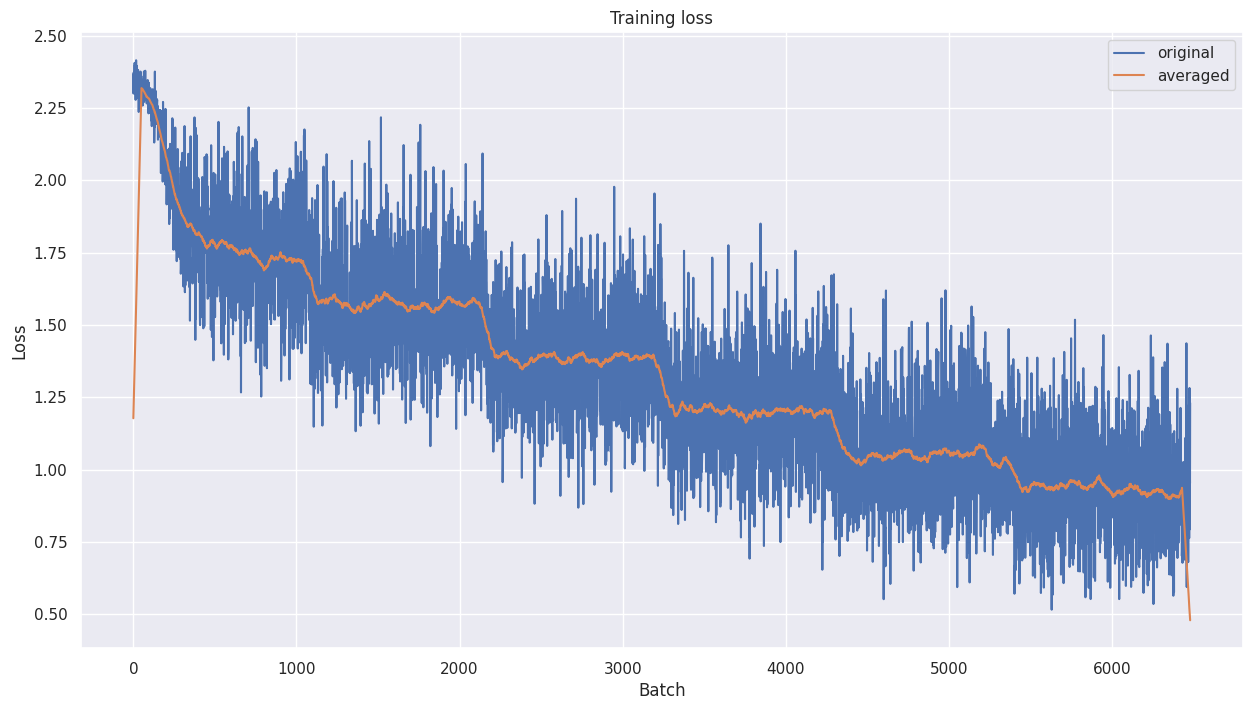

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

In [ ]:
best_model = BertForSequenceClassification.from_pretrained(BERTMODEL, num_labels=len(label_map))
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
print('\nTest set:')
evaluate(test_dataloader, model = best_model)


Test set:
Accuracy: [4315/10800] 0.3995
Classification report:
              precision    recall  f1-score   support

      action       0.34      0.36      0.35      1080
   adventure       0.36      0.32      0.34      1080
       crime       0.37      0.44      0.40      1080
      family       0.47      0.44      0.45      1080
     fantasy       0.37      0.36      0.37      1080
      horror       0.40      0.50      0.45      1080
     mystery       0.33      0.32      0.32      1080
     romance       0.52      0.59      0.55      1080
       scifi       0.46      0.58      0.51      1080
    thriller       0.25      0.09      0.13      1080

    accuracy                           0.40     10800
   macro avg       0.39      0.40      0.39     10800
weighted avg       0.39      0.40      0.39     10800

Confusion matrix:
[[387 110 203  46  60  46  33  42 120  33]
 [121 350  81 135 136  48  30  59 114   6]
 [190  29 474  39   9  42 176  56  28  37]
 [ 65 124  32 474 142  30  21 

0.399537037037037

# change parameters

In [ ]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(label_map))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained BERT model "bert-base-uncased" loaded


In [ ]:
EPOCHS = 6
WEIGHT_DECAY = 0.01
LR = 1e-5 #smaller for the previous zigzag
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_lossv = []
best_accuracy = 0
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    val_accuracy = evaluate(validation_dataloader, model = model)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  #best model



Train Epoch: 1 [0/34560 (0%)]	Loss: 2.307101
Train Epoch: 1 [6400/34560 (19%)]	Loss: 2.312994
Train Epoch: 1 [12800/34560 (37%)]	Loss: 1.862602
Train Epoch: 1 [19200/34560 (56%)]	Loss: 1.777991
Train Epoch: 1 [25600/34560 (74%)]	Loss: 1.710281
Train Epoch: 1 [32000/34560 (93%)]	Loss: 1.408368

Validation set:
Accuracy: [3420/8640] 0.3958
Classification report:
              precision    recall  f1-score   support

      action       0.34      0.28      0.31       823
   adventure       0.31      0.35      0.33       885
       crime       0.35      0.56      0.43       892
      family       0.47      0.46      0.47       833
     fantasy       0.39      0.26      0.31       893
      horror       0.43      0.48      0.45       867
     mystery       0.33      0.32      0.33       857
     romance       0.51      0.56      0.53       874
       scifi       0.44      0.65      0.53       855
    thriller       0.26      0.05      0.09       861

    accuracy                           0

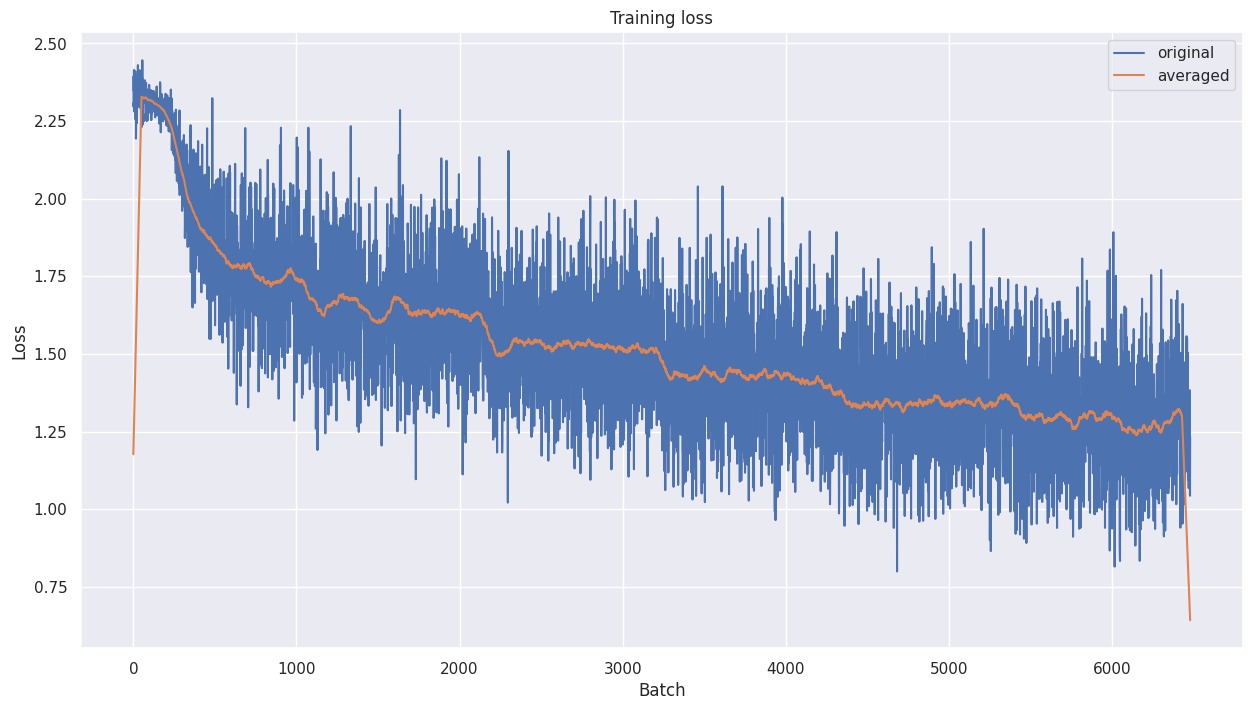

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

In [ ]:
best_model = BertForSequenceClassification.from_pretrained(BERTMODEL, num_labels=len(label_map))
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
print('\nTest set:')
evaluate(test_dataloader, model = best_model)


Test set:
Accuracy: [4375/10800] 0.4051
Classification report:
              precision    recall  f1-score   support

      action       0.36      0.35      0.35      1080
   adventure       0.36      0.30      0.33      1080
       crime       0.38      0.47      0.42      1080
      family       0.45      0.53      0.49      1080
     fantasy       0.39      0.32      0.35      1080
      horror       0.44      0.49      0.46      1080
     mystery       0.34      0.22      0.27      1080
     romance       0.55      0.58      0.57      1080
       scifi       0.43      0.61      0.51      1080
    thriller       0.25      0.17      0.20      1080

    accuracy                           0.41     10800
   macro avg       0.39      0.41      0.39     10800
weighted avg       0.39      0.41      0.39     10800

Confusion matrix:
[[379 116 202  53  48  30  22  36 135  59]
 [125 319  82 178 115  30  22  55 134  20]
 [175  20 509  36   9  43  98  63  31  96]
 [ 48 110  29 575 102  18  15 

0.4050925925925926